<a href="https://colab.research.google.com/github/Dipak22/DeepLearning/blob/master/pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn
torch.__version__

'2.5.1+cu124'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 1. Get Data

Our Dataset is a subset of the Food101 dataset,

It has three classes, and 1000 images per class in train and 750 in training and 250 test.

Here, we are experimenting on small sample set for quick testing and building model.

In [4]:
import requests
import zipfile
from pathlib import Path

data_path = Path('data/')
image_path = data_path/'pizza_steak_sushi'

if image_path.is_dir():
  print(f'It already exists')
else:
  image_path.mkdir(parents=True, exist_ok=True)

In [5]:
# Doenload data
with open(data_path/'pizza_steak_sushi.zip', 'wb') as f:

  request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
  f.write(request.content)

#unzip data

with zipfile.ZipFile(data_path/'pizza_steak_sushi.zip','r') as zip_ref:
  zip_ref.extractall(image_path)


## Data preparation and exploration

In [6]:
import os
def walk_through_dir(dir_path):
  """ Walks through dir_path returning its contents. """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [7]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak


In [8]:
#setup train and testing paths
train_dir = image_path/'train'
test_dir = image_path/'test'
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## Visualizing the image
1. get all the image paths
2. Pick a random image path using Python random.choice()
3. Get the image class naem using `pathlib.Path.parent.stem`
4. open and display the iamge using PILImage
5. show metadata

data/pizza_steak_sushi/train/steak/3518960.jpg
steak
height: 512 width: 384


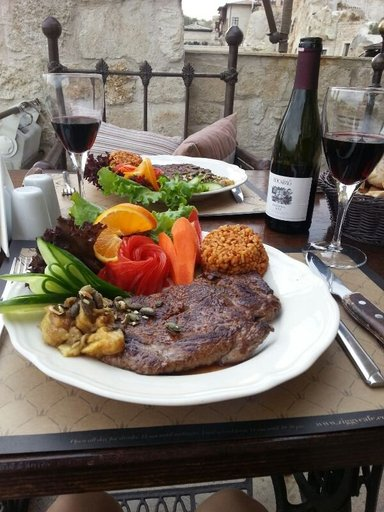

In [9]:
import random
from PIL import Image
image_path_list = list(image_path.glob("*/*/*.jpg"))
image = random.choice(image_path_list)
image_class = image.parent.stem
im = Image.open(image)
print(f"{image}")
print(f"{image_class}")
print(f"height: {im.height} width: {im.width}")
im

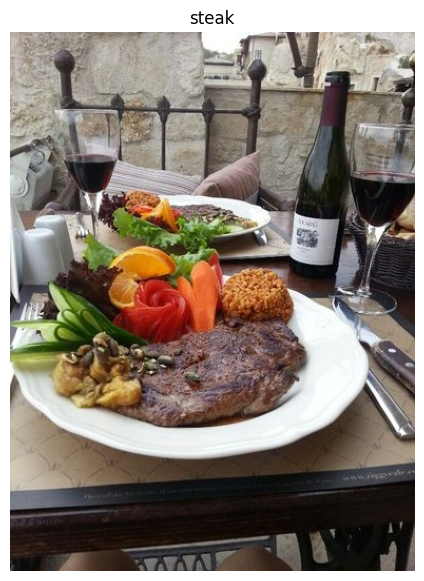

In [10]:
import numpy as np
import matplotlib.pyplot as plt

#turn image in a array
img_as_array = np.asarray(im)
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(image_class)
plt.axis(False);

## Transform data
1) turn images and labels into numbers
2) create datasets for train and test
3) create dataloaders
4) transform/augment the data

In [13]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

Change JPEGImage to tensors

In [14]:
data_transform = transforms.Compose([
    #Resize the images to 64*64
    transforms.Resize(size=(64,64)),
    #Flip the images randomly on the horizontal axis
    transforms.RandomHorizontalFlip(p=0.5),
    #Turn image to tensor
    transforms.ToTensor()
])

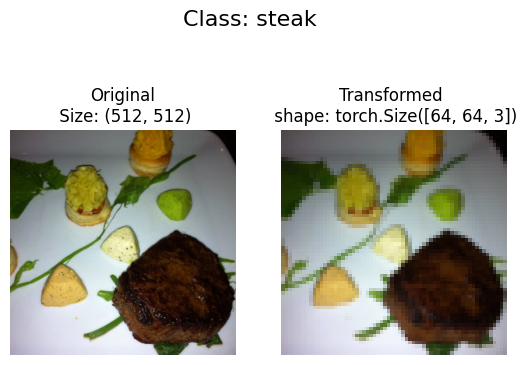

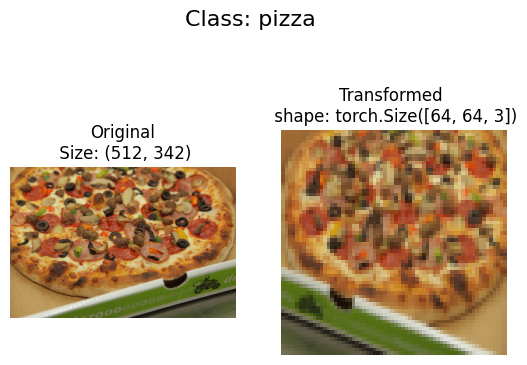

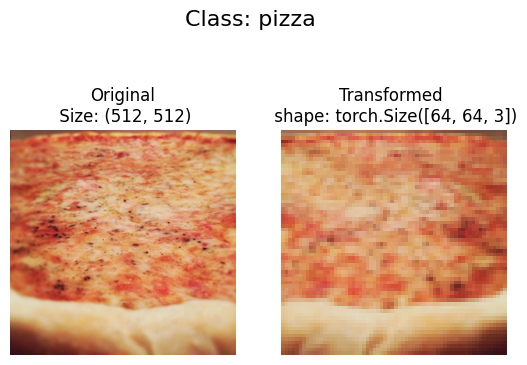

In [20]:
def plot_transformed_images(image_paths, transform, n=3, seed =42):
    """
    Selects random images from a path of images,loads and transforms them
    then plots teh original v transformed
    """
    if seed:
      random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
      with Image.open(image_path) as f:
        fig, ax = plt.subplots(nrows =1, ncols =2)
        ax[0].imshow(f)
        ax[0].set_title(f"Original\n Size: {f.size}")
        ax[0].axis(False)

        #Transform and plot target image
        transformed_image = transform(f).permute(1,2,0)
        ax[1].imshow(transformed_image)
        ax[1].set_title(f"Transformed \n shape: {transformed_image.shape}")
        ax[1].axis(False)

        fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images( image_paths=image_path_list,
                        transform=data_transform,
                         n=3)

## Loading image data using ImageFolder

We can load image classification data using `torchvision.datasets.ImageFolder`

In [21]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform = None,
                                  )
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [35]:
class_labels = train_data.classes

In [25]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [26]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [29]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [31]:
# Index on the train_data Dataset to get single image and label
img, label = train_data[0][0], train_data[0][1]
img, label

(tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
          [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
          [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
          ...,
          [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
          [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
          [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],
 
         [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
          [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
          [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
          ...,
          [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
          [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
          [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],
 
         [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
          [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
          [0.0902, 0.0902, 0.0902,  ...,

In [34]:
img.shape, type(label)

(torch.Size([3, 64, 64]), int)

In [37]:
img_permute = img.permute(1,2,0)
img.shape, img_permute.shape

(torch.Size([3, 64, 64]), torch.Size([64, 64, 3]))

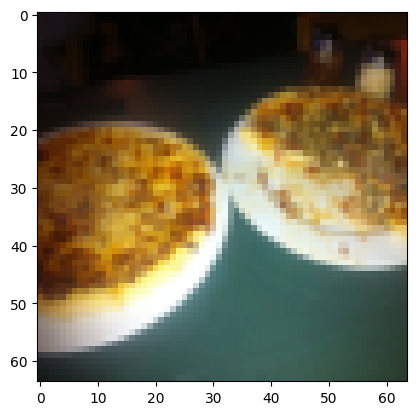

In [38]:
plt.imshow(img_permute)

## create dataloaders

In [45]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [46]:
sample_img, sample_label = next(iter(train_dataloader))

In [47]:
sample_img.shape, sample_label.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

In [44]:
len(train_dataloader), len(test_dataloader)

(8, 3)

## Option 2: Loading Image data with a custom `Dataset`
1. load images from files
2. get class_names from folder or files
3. get classes as dictionary from the dataset

In [49]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

## craeting a helper fucntyion to get class names

1. we want to traverse a target directory and ideally should be in stanadard folder structure
2. raise an error if the class names are not found
3. turn class names as dict and list.

In [51]:
target_directory = train_dir
# get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
print(class_names_found)

['pizza', 'steak', 'sushi']


In [52]:
def find_classes(directory: str)-> Tuple[List[str], Dict[str, int]]:
  # get the class_names
  classes = sorted([entry.name for entry in list(os.scandir(directory)) if entry.is_dir()])
  # raise an error when classes are not present
  if not classes:
    raise FileNotFoundError(f" coud not find any classes in {directory}")

  # create a dict
  class_to_idx = {class_name : i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [53]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## Create a custom `Dataset` to replicate `ImageFolder`

1. subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory
3. create several attributes
  paths
  transform
  classes
  class_to_idx

3. create a function to `load_images` , this fn will open the image
4. overwrite `__len()__`
5 overwrite `__getitem()__`

In [54]:
from torch.utils.data import Dataset
# subclass Dataset
class ImageFolderCustom(Dataset):
  def __init__(self,
               targ_dir,
               transform = None) -> None:
    super().__init__()
    # get all of the image_paths
    self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg'))
    #setup transforms
    self.transform = transform
    # create classes and class_to_idx
    self.classes, self.class_to_idx = find_classes(targ_dir)
  # create a function to load image
  def load_image(self, index:int)-> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  # overwrite __len__()
  def __len__(self)->int:
    return len(self.paths)
  # overwrite __item__()
  def __getitem__(self, index: int)-> Tuple[torch.tensor, int]:
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]
    if self.transform:
      return self.transform(img), class_idx
    return img, class_idx


In [55]:
#create a transform
train_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()])

test_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()])

In [56]:
train_data_custom = ImageFolderCustom(targ_dir= train_dir,
                                      transform=train_transform)
test_data_custom = ImageFolderCustom(targ_dir= test_dir,
                                     transform=test_transform)

In [58]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [60]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [61]:
# check for equality between original and custom datasets
print(train_data_custom.classes == train_data.classes)

True


## Create a fucntion to display random images
1. Take in a `Dataset` and number of other parameters such as class names and how many images to visualize
2. to prevent the display getting out of hand
3. set the random seed
4. get a list of random sample indexes from the target dataset
5. setup matplotlib


In [82]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n : int = 10,
                          display_shape : bool = True,
                          seed: int = None):
  if n>10:
    n = 10
    display_shape = False
  if seed:
    random.seed(seed)
  # get random sample indexes
  random_sample_idx  = random.sample(range(len(dataset)), k = n)
  #setup plot
  plt.figure(figsize=(10,9))
  #loop through random images
  i=1
  for idx in random_sample_idx:
    image, label = dataset[idx]
    targ_image= image.permute(1,2,0)
    #plot the image
    plt.subplot(1, n,i)
    i +=1
    plt.imshow(targ_image)
    plt.axis('off')
    if classes:
      title =f'Class: {classes[label]}'
      if display_shape:
        title = title + f"\nShape: {targ_image.shape}"
    plt.title(title)


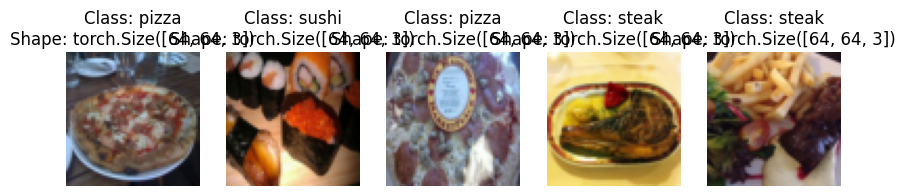

In [85]:
display_random_images(train_data_custom,
                      train_data_custom.classes,
                      n=5,
                      display_shape=True,
                      seed=None)

In [88]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=1,
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=os.cpu_count(),
                                    shuffle=False)

In [89]:
len(train_dataloader_custom), len(test_dataloader_custom)

(8, 3)

## Data Augmentation

In [90]:
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [91]:
image_path_list[:5]

[PosixPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/714866.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/309892.jpg')]

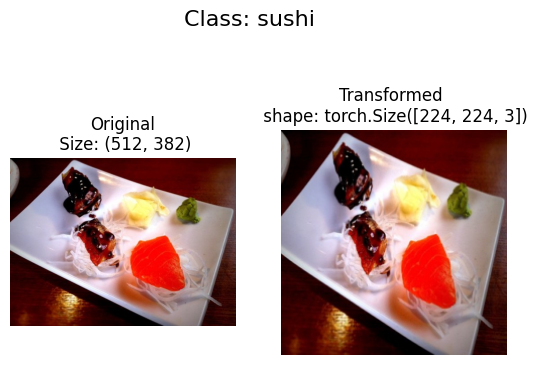

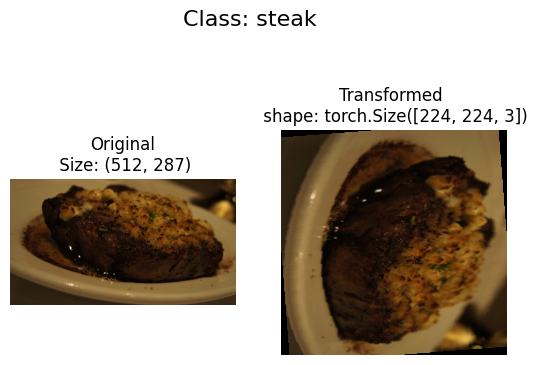

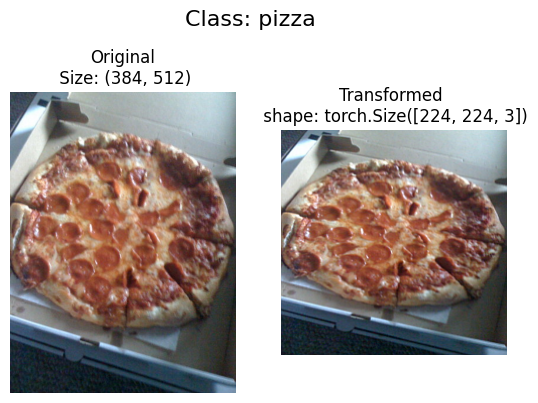

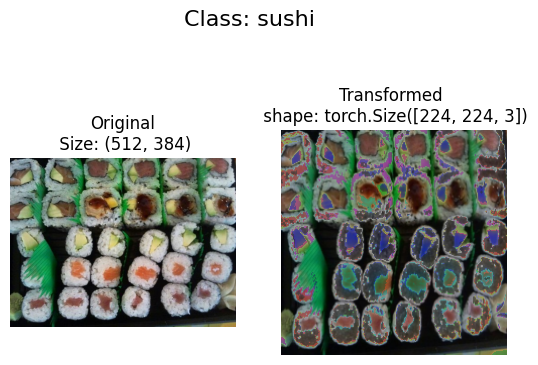

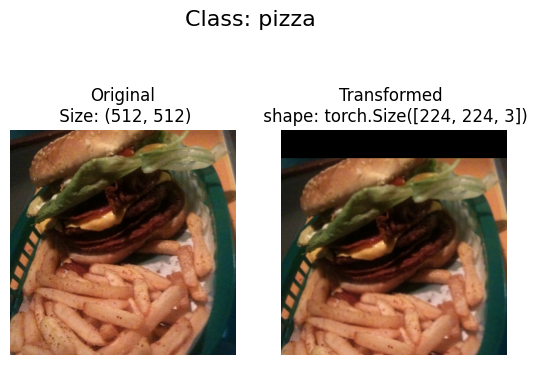

In [92]:
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transform,
                        n=5,
                        seed=None)

## Model_0 : TinyVGG without data augmentation

### Creating transforms and load data

In [93]:
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()])

In [96]:
# load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root= test_dir,
                                        transform=simple_transform)

# create data loaders

BATCH_SIZE = 32
num_workers = os.cpu_count()

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=num_workers)
test_datalaoder_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=num_workers,
                                    shuffle=False)

### Create TinyVGG Model class

In [105]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features= hidden_units * 256,
                  out_features= output_shape)
    )
  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    y = self.classifier(x)
    return y

In [155]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape= 3,
                  hidden_units=10,
                  output_shape=len(class_labels)).to(device)

In [107]:
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [103]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [109]:
model_0(image_batch).shape

torch.Size([32, 3])

In [111]:
!pip install torchinfo

In [146]:
from torchinfo import summary
summary(model_0, input_size=[32,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 10, 64, 64]          280
│    └─ReLU: 2-2                         [32, 10, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 10, 64, 64]          910
│    └─ReLU: 2-4                         [32, 10, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 10, 32, 32]          --
├─Sequential: 1-2                        [32, 10, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 10, 32, 32]          910
│    └─ReLU: 2-7                         [32, 10, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 10, 32, 32]          910
│    └─ReLU: 2-9                         [32, 10, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 10, 16, 16]          --
├─Sequentia

In [156]:
def train_step(model: torch.nn.Module,
               dataloader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device):
  model.train()
  train_loss = 0
  acc = 0
  for batch, (X, y) in enumerate(dataloader):
    X,y = X.to(device), y.to(device)
    y_logits = model(X)
    loss = loss_fn(y_logits, y)
    train_loss +=loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_pred = torch.argmax(torch.softmax(y_logits, dim =1), dim =1)
    acc += (y_pred == y).sum().item()/len(y_pred)
  train_loss /=len(dataloader)
  acc /=len(dataloader)
  return train_loss,acc

def test_step(model: torch.nn.Module,
               dataloader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
                device):
  model.eval()
  test_loss = 0
  acc =0
  for batch, (X, y) in enumerate(dataloader):
    X,y = X.to(device), y.to(device)
    with torch.inference_mode():
      y_logits = model(X)
    loss = loss_fn(y_logits, y)
    test_loss +=loss.item()
    y_pred = torch.argmax(torch.softmax(y_logits, dim =1), dim =1)
    acc += (y_pred == y).sum().item()/len(y_pred)

  test_loss /=len(dataloader)
  acc /=len(dataloader)
  return test_loss, acc

###mcreate `train()` funtion to call train_step() and test_step()

In [157]:
from tqdm.auto import tqdm
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          device = device,
          epochs : int = 3):
  results = {'train_loss':[],
             'train_acc':[],
             'test_loss':[],
             'test_acc': []}
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model,
                            dataloader=train_dataloader,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            device = device)
    test_loss, test_acc = test_step(model=  model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device= device)
    print(f"Epoch: {epoch} | Train loss: {train_loss} | Test loss: {test_loss} | Test acc: {test_acc}")

    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

  return results

In [158]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params= model_0.parameters(),
                            lr = 0.001)
epochs = 5
from timeit import default_timer as timer
start_time = timer()
model_0_results = train(model=model_0,
                train_dataloader= train_dataloader_simple,
                test_dataloader=test_datalaoder_simple,
                loss_fn= loss_fn,
                optimizer= optimizer,
                device=device,
                epochs=epochs)
end_time = timer()
print(f"TOtal training time: {end_time - start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1078356802463531 | Test loss: 1.1362075408299763 | Test acc: 0.2604166666666667
Epoch: 1 | Train loss: 1.0846447050571442 | Test loss: 1.1621677875518799 | Test acc: 0.19791666666666666
Epoch: 2 | Train loss: 1.115324005484581 | Test loss: 1.169554313023885 | Test acc: 0.19791666666666666
Epoch: 3 | Train loss: 1.0988122373819351 | Test loss: 1.134403904279073 | Test acc: 0.19791666666666666
Epoch: 4 | Train loss: 1.0989950597286224 | Test loss: 1.1433987617492676 | Test acc: 0.19791666666666666
TOtal training time: 7.223 seconds


In [160]:
def plot_loss_curves(results: Dict[str,List[float]]):
  loss = results['train_loss']
  acc = results['train_acc']
  test_loss = results['test_loss']
  test_acc = results['test_acc']
  epochs = range(len(results['test_acc']))

  plt.figure(figsize=(15,7))

  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label = 'train_loss')
  plt.plot(epochs, test_loss, label = 'test_loss')
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, acc, label = 'test_accuracy')
  plt.plot(epochs, test_acc, label = 'test_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epoch')
  plt.legend();


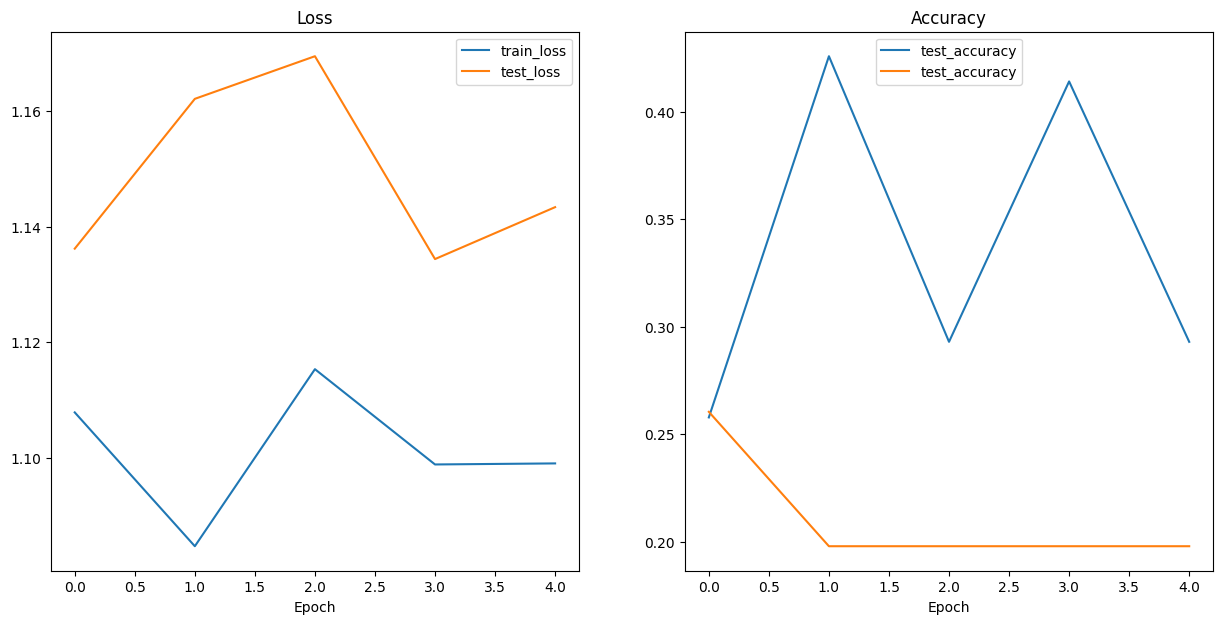

In [161]:
plot_loss_curves(model_0_results)

### new model with data augmentation

In [164]:
from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.ToTensor()
])

### create new train and test dataset and dataloaders

In [165]:
from torchvision import datasets
train_data_aug = datasets.ImageFolder(
    root=train_dir,
    transform=train_transform_trivial,
)

test_data_simple = datasets.ImageFolder(
    root=test_dir,
    transform=test_transform_simple
)

In [167]:
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
torch.manual_seed(42)

train_dataloader_aug = DataLoader(dataset=train_data_aug,
                                  batch_size=BATCH_SIZE,
                                  num_workers=NUM_WORKERS,
                                  shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                 batch_size=BATCH_SIZE,
                                 shuffle=False,
                                 num_workers=NUM_WORKERS)

In [170]:
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_aug.classes)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr = 0.001)

epochs = 5
from timeit import default_timer as timer
start_time = timer()
model_1_results = train(model=model_1,
                train_dataloader= train_dataloader_aug,
                test_dataloader=test_dataloader_simple,
                loss_fn= loss_fn,
                optimizer= optimizer,
                device=device,
                epochs=epochs)
end_time = timer()
print(f"TOtal training time: {end_time - start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1070075184106827 | Test loss: 1.1383054653803508 | Test acc: 0.2604166666666667
Epoch: 1 | Train loss: 1.0826760455965996 | Test loss: 1.1680548985799153 | Test acc: 0.19791666666666666
Epoch: 2 | Train loss: 1.1221406012773514 | Test loss: 1.1739853620529175 | Test acc: 0.19791666666666666
Epoch: 3 | Train loss: 1.0955269038677216 | Test loss: 1.1426928838094075 | Test acc: 0.20833333333333334
Epoch: 4 | Train loss: 1.0946428626775742 | Test loss: 1.141881783803304 | Test acc: 0.21875
TOtal training time: 8.556 seconds


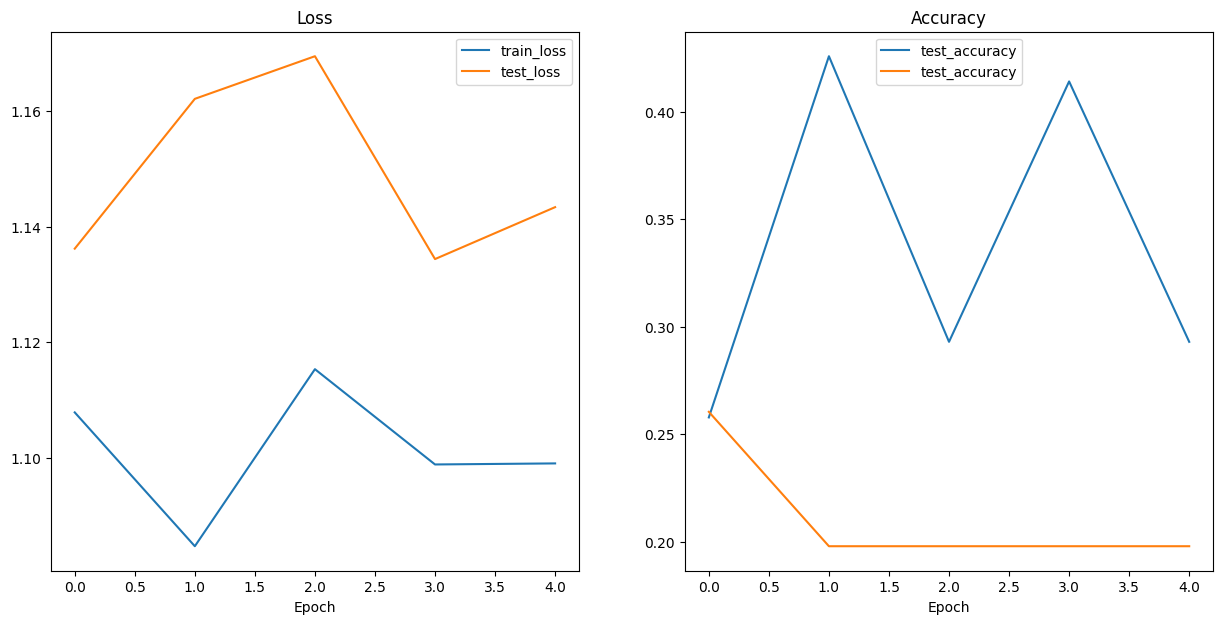

In [172]:
plot_loss_curves(model_0_results)

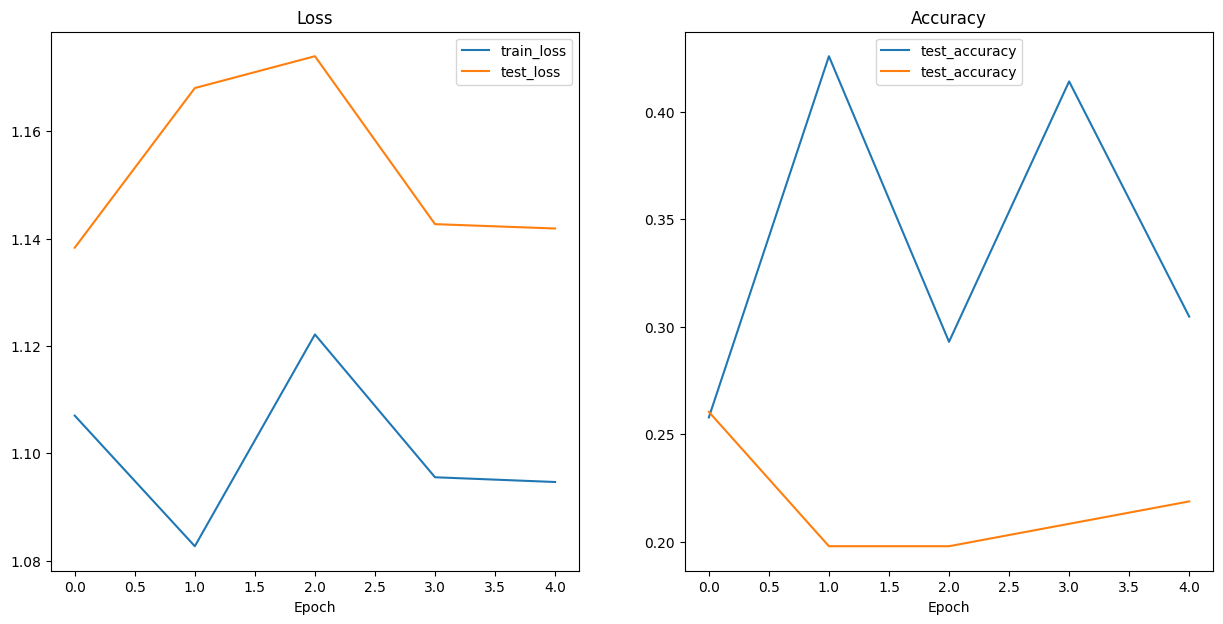

In [171]:
plot_loss_curves(model_1_results)

In [173]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

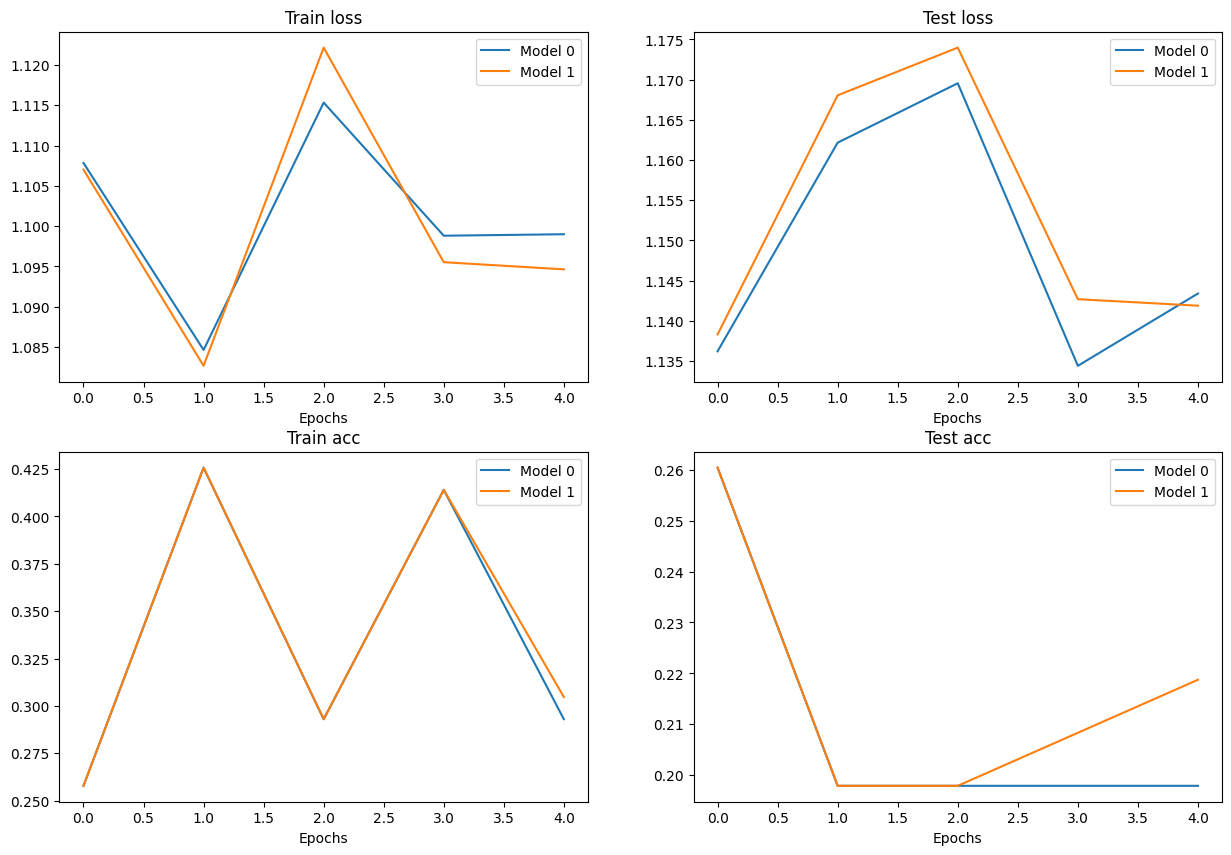

In [176]:
plt.figure(figsize = (15,10))
epochs = range(len(model_0_df))
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df['train_loss'], label='Model 0')
plt.plot(epochs, model_1_df['train_loss'], label = 'Model 1')
plt.title('Train loss')
plt.xlabel('Epochs')
plt.legend();
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df['test_loss'], label='Model 0')
plt.plot(epochs, model_1_df['test_loss'], label = 'Model 1')
plt.title('Test loss')
plt.xlabel('Epochs')
plt.legend();
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df['train_acc'], label='Model 0')
plt.plot(epochs, model_1_df['train_acc'], label = 'Model 1')
plt.title('Train acc')
plt.xlabel('Epochs')
plt.legend();
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df['test_acc'], label='Model 0')
plt.plot(epochs, model_1_df['test_acc'], label = 'Model 1')
plt.title('Test acc')
plt.xlabel('Epochs')
plt.legend();

In [178]:
### Making a prediction
import requests
custom_image_path = data_path /'04-pizza-dad.jpeg'

if not custom_image_path.is_file():
  with open(custom_image_path,'wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg')
    f.write(request.content)

### Loading in a custom image with Pytorch


In [180]:
import torchvision
#Read in custom_image
custom_im_u8 = torchvision.io.read_image(str(custom_image_path))

In [181]:
custom_im_u8.shape

torch.Size([3, 4032, 3024])

In [188]:
#load image and convert to torch.tensor
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)/255.0
custom_image.dtype, custom_image.shape

(torch.float32, torch.Size([3, 4032, 3024]))

In [189]:
custom_image = custom_image.to(device)

In [190]:
#Resize the image
custom_image_transform = transforms.Compose([transforms.Resize(size=(64,64))])

In [191]:
custom_image_transformed = custom_image_transform(custom_image)
custom_image.shape, custom_image_transformed.shape

(torch.Size([3, 4032, 3024]), torch.Size([3, 64, 64]))

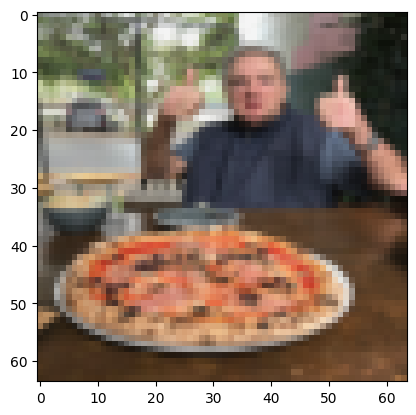

In [192]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [194]:
with torch.inference_mode():
  custom_pred = model_1(custom_image_transformed.unsqueeze(0))
  pred_label = torch.argmax(custom_pred, dim = 1)
class_labels[pred_label]

'steak'

### Putting custom image prediction together
- args - image_path
- output - plot with title


In [205]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path : str,
                        class_names : List[str] = None,
                        transform = None,
                        device = device):
  """
  Makes a prediction on a target image with trained model and plots the image and predictions
  """
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
  target_image /=255.0

  if transform :
    target_image = transform(target_image)
  model.to(device)
  target_image = target_image.unsqueeze(0).to(device)
  model.eval()
  with torch.inference_mode():
    logits = model(target_image)
  probs = torch.softmax(logits, dim = 1).cpu()
  idx = torch.argmax(probs, dim = 1);
  label = class_names[idx]
  plt.imshow(target_image.cpu().squeeze().permute(1,2,0))
  plt.axis(False)
  if class_names:
    title = f"Pred : {label} | Prob: {probs.max():.2f}"
  plt.title(title)

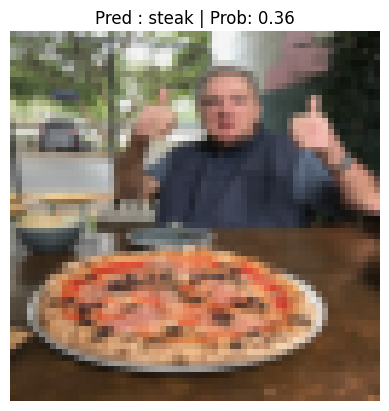

In [207]:
pred_and_plot_image(model = model_1,
                    image_path=custom_image_path,
                    class_names= class_labels,
                    transform= custom_image_transform)